In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Define the CNN architecture
class PlantVillageCNN(nn.Module):
    def __init__(self):
        super(PlantVillageCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 16, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(16, 8, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(8 * 16 * 16, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool1(nn.functional.relu(self.conv1(x)))
        x = self.pool2(nn.functional.relu(self.conv2(x)))
        x = self.pool3(nn.functional.relu(self.conv3(x)))
        x = x.view(-1, 8 * 16 * 16)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(128),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(128),
        transforms.CenterCrop(128),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [5]:
# Load the datasets
train_dataset = ImageFolder('../Datasets/train', transform=data_transforms['train'])
val_dataset = ImageFolder('../Datasets/val', transform=data_transforms['val'])


In [6]:

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [7]:
model = PlantVillageCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())


In [8]:
# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    
    # Training loop
    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        # Move data to device
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation - now done every epoch instead of every 100 epochs
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc='Validating'):
            # Move data to device
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_loss += criterion(outputs, labels).item()

    val_accuracy = val_correct / val_total
    
    # Print metrics
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Training Loss: {running_loss/len(train_loader):.4f}')
    print(f'Validation Loss: {val_loss/len(val_loader):.4f}')
    print(f'Validation Accuracy: {val_accuracy:.4f}')
    print('-' * 50)

print('Training completed!')

Validating: 100%|██████████| 16/16 [00:12<00:00,  1.27it/s]


Epoch [1/10]
Training Loss: 1.8819
Validation Loss: 1.3858
Validation Accuracy: 0.5320
--------------------------------------------------


Validating: 100%|██████████| 16/16 [00:02<00:00,  6.72it/s]


Epoch [2/10]
Training Loss: 1.3307
Validation Loss: 1.0260
Validation Accuracy: 0.6310
--------------------------------------------------


Validating: 100%|██████████| 16/16 [00:02<00:00,  7.49it/s]


Epoch [3/10]
Training Loss: 1.1460
Validation Loss: 0.9142
Validation Accuracy: 0.6500
--------------------------------------------------


Validating: 100%|██████████| 16/16 [00:02<00:00,  7.11it/s]


Epoch [4/10]
Training Loss: 1.0410
Validation Loss: 0.7810
Validation Accuracy: 0.6970
--------------------------------------------------


Validating: 100%|██████████| 16/16 [00:02<00:00,  7.25it/s]


Epoch [5/10]
Training Loss: 0.9911
Validation Loss: 0.7560
Validation Accuracy: 0.7320
--------------------------------------------------


Validating: 100%|██████████| 16/16 [00:02<00:00,  7.42it/s]


Epoch [6/10]
Training Loss: 0.9233
Validation Loss: 0.8629
Validation Accuracy: 0.6960
--------------------------------------------------


Validating: 100%|██████████| 16/16 [00:02<00:00,  6.28it/s]


Epoch [7/10]
Training Loss: 0.8766
Validation Loss: 0.6732
Validation Accuracy: 0.7440
--------------------------------------------------


Validating: 100%|██████████| 16/16 [00:02<00:00,  5.84it/s]


Epoch [8/10]
Training Loss: 0.8354
Validation Loss: 0.6703
Validation Accuracy: 0.7500
--------------------------------------------------


Validating: 100%|██████████| 16/16 [00:02<00:00,  6.26it/s]


Epoch [9/10]
Training Loss: 0.8006
Validation Loss: 0.6631
Validation Accuracy: 0.7650
--------------------------------------------------


Validating: 100%|██████████| 16/16 [00:02<00:00,  6.52it/s]

Epoch [10/10]
Training Loss: 0.8052
Validation Loss: 0.6049
Validation Accuracy: 0.7870
--------------------------------------------------
Training completed!


Keeping a copy of the original weights (cloning them) so later we can prove that a fine-tuning with LoRA doesn't alter the original weights

In [13]:
original_weights = {}
for name, param in model.named_parameters():
    original_weights[name] = param.clone().detach()

The the performance of the pretrained network. As we can see, the network performs poorly on the digit 9. Let's fine-tune it on the digit 9

In [23]:
class_labels = ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy',
                'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot',
                'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot',
                'Tomato___Tomato_mosaic_virus', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus']

# First, make sure model is on the correct device
model.eval()

correct = 0
total = 0
wrong_counts = [0 for _ in range(len(class_labels))]
accuracies = []  # Initialize the accuracies list here

with torch.no_grad():
    for data in tqdm(val_loader, desc='Testing'):
        x, y = data
        x = x.to(device)
        y = y.to(device)
        
        outputs = model(x)
        
        for idx, output in enumerate(outputs):
            predicted = torch.argmax(output)
            if predicted == y[idx]:
                correct += 1
            else:
                wrong_counts[y[idx].item()] += 1
            total += 1

overall_accuracy = round(correct/total, 3)
print(f'Overall Accuracy: {overall_accuracy}')

# Print wrong predictions and collect accuracies
for i in range(len(wrong_counts)):
    print(f'Wrong predictions for class {class_labels[i]}: {wrong_counts[i]}')
    class_total = sum(1 for _, label in val_loader.dataset if label == i)
    class_accuracy = round((class_total - wrong_counts[i]) / class_total, 3)
    accuracies.append(int(class_accuracy*100))  # Add accuracy to the list
    print(f'Class {class_labels[i]} Accuracy: {class_accuracy}')


Testing: 100%|██████████| 16/16 [00:02<00:00,  6.20it/s]


Overall Accuracy: 0.787
Wrong predictions for class Tomato___Bacterial_spot: 69
Class Tomato___Bacterial_spot Accuracy: 0.31
Wrong predictions for class Tomato___Early_blight: 28
Class Tomato___Early_blight Accuracy: 0.72
Wrong predictions for class Tomato___healthy: 34
Class Tomato___healthy Accuracy: 0.66
Wrong predictions for class Tomato___Late_blight: 8
Class Tomato___Late_blight Accuracy: 0.92
Wrong predictions for class Tomato___Leaf_Mold: 16
Class Tomato___Leaf_Mold Accuracy: 0.84
Wrong predictions for class Tomato___Septoria_leaf_spot: 12
Class Tomato___Septoria_leaf_spot Accuracy: 0.88
Wrong predictions for class Tomato___Spider_mites Two-spotted_spider_mite: 20
Class Tomato___Spider_mites Two-spotted_spider_mite Accuracy: 0.8
Wrong predictions for class Tomato___Target_Spot: 8
Class Tomato___Target_Spot Accuracy: 0.92
Wrong predictions for class Tomato___Tomato_mosaic_virus: 3
Class Tomato___Tomato_mosaic_virus Accuracy: 0.97
Wrong predictions for class Tomato___Tomato_Yello

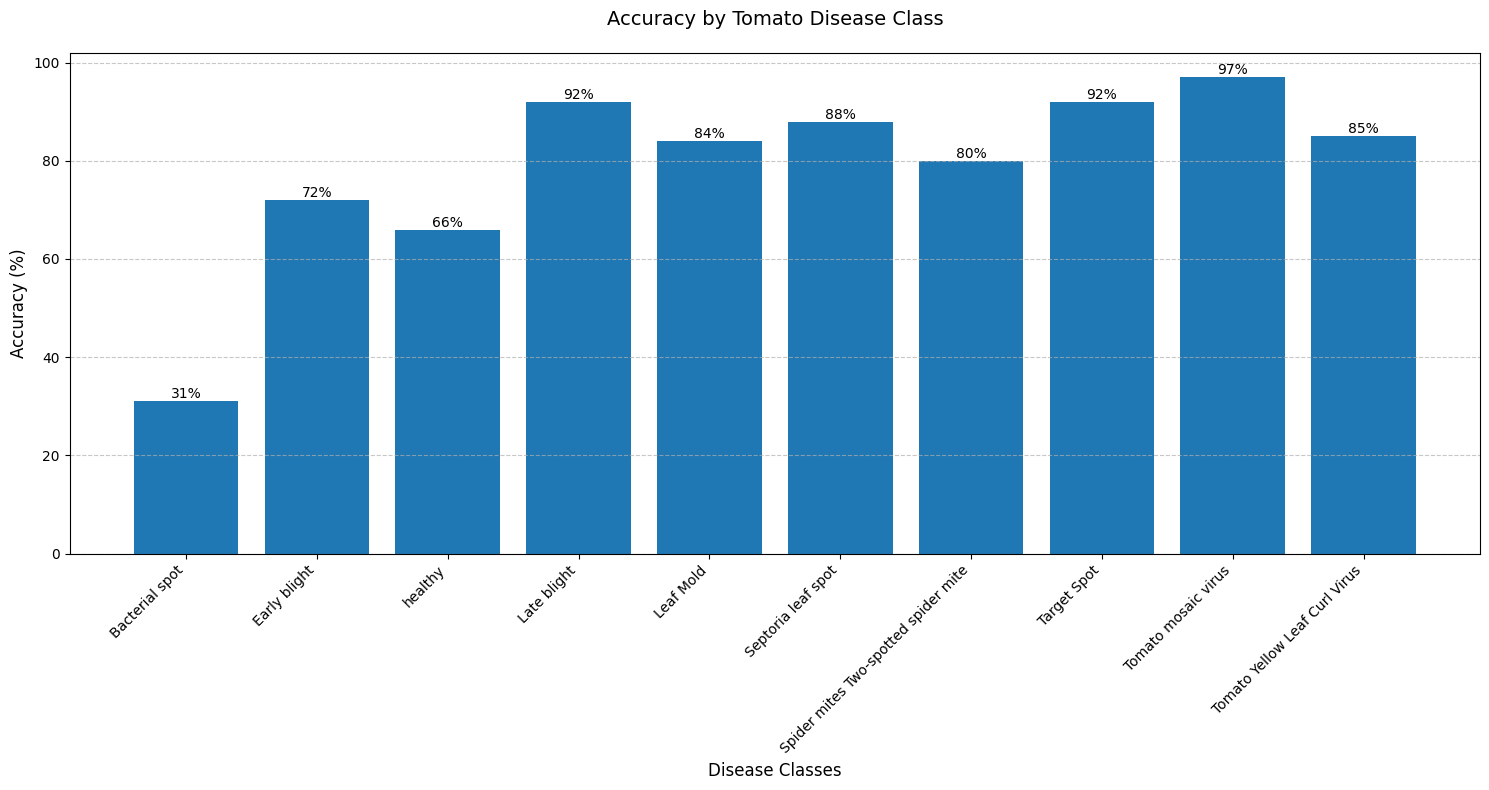

In [24]:
import matplotlib.pyplot as plt
# Now create the plot with the collected accuracies
plt.figure(figsize=(15, 8))
shortened_labels = [label.split('___')[-1].replace('_', ' ') for label in class_labels]

bars = plt.bar(shortened_labels, accuracies)
plt.title('Accuracy by Tomato Disease Class', fontsize=14, pad=20)
plt.xlabel('Disease Classes', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height}%',
            ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, max(accuracies) + 5)  # Add some padding at the top
plt.tight_layout()
plt.show()

Let's visualize how many parameters are in the original network, before introducing the LoRA matrices.

In [25]:
# Initialize the total parameters counter
total_parameters_original = 0

# Iterate over all layers in the model
for index, layer in enumerate(model.children()):
    if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
        total_parameters_original += layer.weight.nelement()
        if layer.bias is not None:
            total_parameters_original += layer.bias.nelement()
        print(f'Layer {index+1}: W: {layer.weight.shape} + B: {layer.bias.shape if layer.bias is not None else "N/A"}')

print(f'Total number of parameters: {total_parameters_original:,}')

Layer 1: W: torch.Size([32, 3, 3, 3]) + B: torch.Size([32])
Layer 3: W: torch.Size([16, 32, 3, 3]) + B: torch.Size([16])
Layer 5: W: torch.Size([8, 16, 3, 3]) + B: torch.Size([8])
Layer 7: W: torch.Size([128, 2048]) + B: torch.Size([128])
Layer 9: W: torch.Size([10, 128]) + B: torch.Size([10])
Total number of parameters: 270,242


In [26]:
# # Save the trained modeln 
# torch.save(model.state_dict(), 'sequential_model.pth')
# print('Saved trained model as sequential_model.pth')